<a href="https://colab.research.google.com/github/helena4430/20242R0136COSE47402/blob/main/final%20project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-zskx6ce4
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-zskx6ce4
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.7 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=9a8aa51df42d41c625ab6f8c49b3a78abe03e2f29b6de8f703ff7d872d9c6353
  Stored in directory: /tmp/pip-ephem-wheel-cache-3kvyw7dj/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [ ]:
import torch
import clip
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import torch.nn as nn
from sklearn.metrics import accuracy_score
import numpy as np


device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device)


clip_model = clip_model.to(torch.float32)


for param in clip_model.parameters():
    param.requires_grad = False


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
])


train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


subset_indices = list(range(1000))
train_subset = Subset(train_dataset, subset_indices)


train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


class CLIPClassifier(nn.Module):
    def __init__(self, clip_model, num_classes=10):
        super(CLIPClassifier, self).__init__()
        self.clip_model = clip_model
        self.fc = nn.Linear(512, num_classes)

    def forward(self, images):
        images = images.to(torch.float32)
        with torch.no_grad():
            image_features = self.clip_model.encode_image(images)
        logits = self.fc(image_features)
        return logits


model = CLIPClassifier(clip_model=clip_model).to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-4)  # Only train the classifier


num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)


        images = images.to(torch.float32)


        outputs = model(images)
        loss = criterion(outputs, labels)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")


def evaluate(model, data_loader):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    return accuracy


accuracy = evaluate(model, test_loader)
print(f"\nTest Accuracy: {accuracy:.4f}")


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Loss: 2.2526
Epoch 2/10, Loss: 2.1297
Epoch 3/10, Loss: 2.0267
Epoch 4/10, Loss: 1.9341
Epoch 5/10, Loss: 1.8379
Epoch 6/10, Loss: 1.7497
Epoch 7/10, Loss: 1.6717
Epoch 8/10, Loss: 1.5934
Epoch 9/10, Loss: 1.5204
Epoch 10/10, Loss: 1.4509

Test Accuracy: 0.8718


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Loss: 2.2083
Epoch 2/10, Loss: 1.9562
Epoch 3/10, Loss: 1.6109
Epoch 4/10, Loss: 1.1846
Epoch 5/10, Loss: 0.8065
Epoch 6/10, Loss: 0.5629
Epoch 7/10, Loss: 0.4394
Epoch 8/10, Loss: 0.3575
Epoch 9/10, Loss: 0.3163
Epoch 10/10, Loss: 0.2859
Test Accuracy: 0.9106


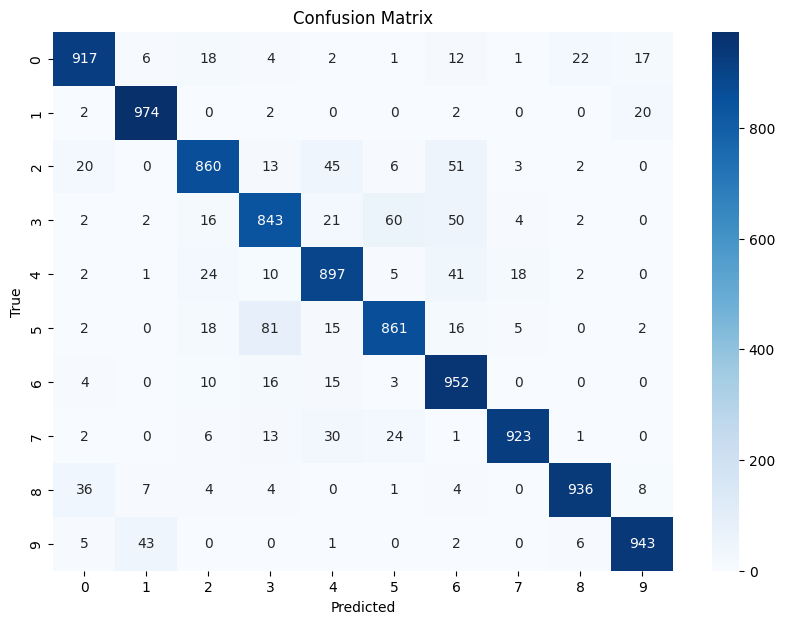

Epoch [1/10], Loss: 0.2489, Accuracy: 90.82%
Epoch [2/10], Loss: 0.2396, Accuracy: 91.29%
Epoch [3/10], Loss: 0.2109, Accuracy: 91.43%
Epoch [4/10], Loss: 0.2061, Accuracy: 91.42%
Epoch [5/10], Loss: 0.1844, Accuracy: 91.15%
Epoch [6/10], Loss: 0.1781, Accuracy: 91.60%
Epoch [7/10], Loss: 0.1636, Accuracy: 91.70%
Epoch [8/10], Loss: 0.1622, Accuracy: 91.64%
Epoch [9/10], Loss: 0.1471, Accuracy: 91.56%
Epoch [10/10], Loss: 0.1411, Accuracy: 91.51%


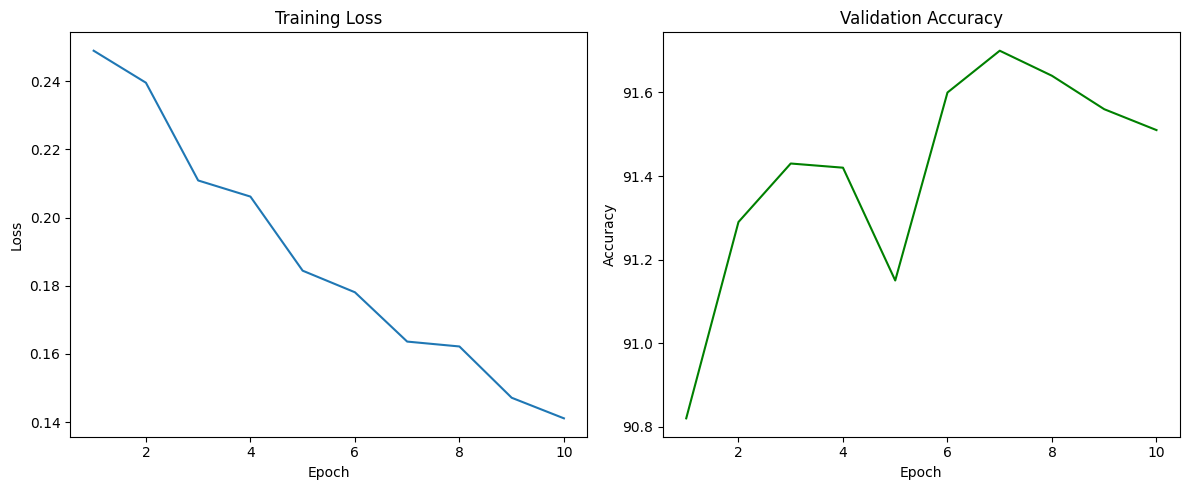

In [11]:
import torch
import clip
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device)


for param in clip_model.parameters():
    param.requires_grad = False


clip_model = clip_model.to(torch.float32)


class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction_ratio)
        self.fc2 = nn.Linear(in_channels // reduction_ratio, in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size, channels, _, _ = x.size()
        y = x.mean(dim=[2, 3], keepdim=True)
        y = self.fc1(y.view(batch_size, channels))
        y = self.fc2(y)
        y = self.sigmoid(y).view(batch_size, channels, 1, 1)
        return x * y


class ClipSENet(nn.Module):
    def __init__(self, clip_model, num_classes=10):
        super(ClipSENet, self).__init__()
        self.clip_model = clip_model
        self.se_block = SEBlock(512)
        self.fc1 = nn.Linear(512, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, images):

        with torch.no_grad():
            image_features = self.clip_model.encode_image(images)


        image_features = self.se_block(image_features.unsqueeze(-1).unsqueeze(-1))
        image_features = image_features.squeeze(-1).squeeze(-1)


        x = torch.relu(self.fc1(image_features))
        logits = self.fc2(x)
        return logits


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


subset_indices = list(range(1000))
train_subset = Subset(train_dataset, subset_indices)

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


model = ClipSENet(clip_model=clip_model).to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)


        images = images.to(torch.float32)


        outputs = model(images)
        loss = criterion(outputs, labels)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")


def evaluate(model, data_loader):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    return accuracy


accuracy = evaluate(model, test_loader)
print(f"Test Accuracy: {accuracy:.4f}")


def plot_confusion_matrix(model, data_loader, classes):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions)


    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


classes = [str(i) for i in range(10)]
plot_confusion_matrix(model, test_loader, classes)

train_losses = []
valid_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()


    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        valid_accuracies.append(accuracy)

    train_losses.append(running_loss / len(train_loader))

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")


plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')


plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), valid_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')

plt.tight_layout()
plt.show()


Files already downloaded and verified


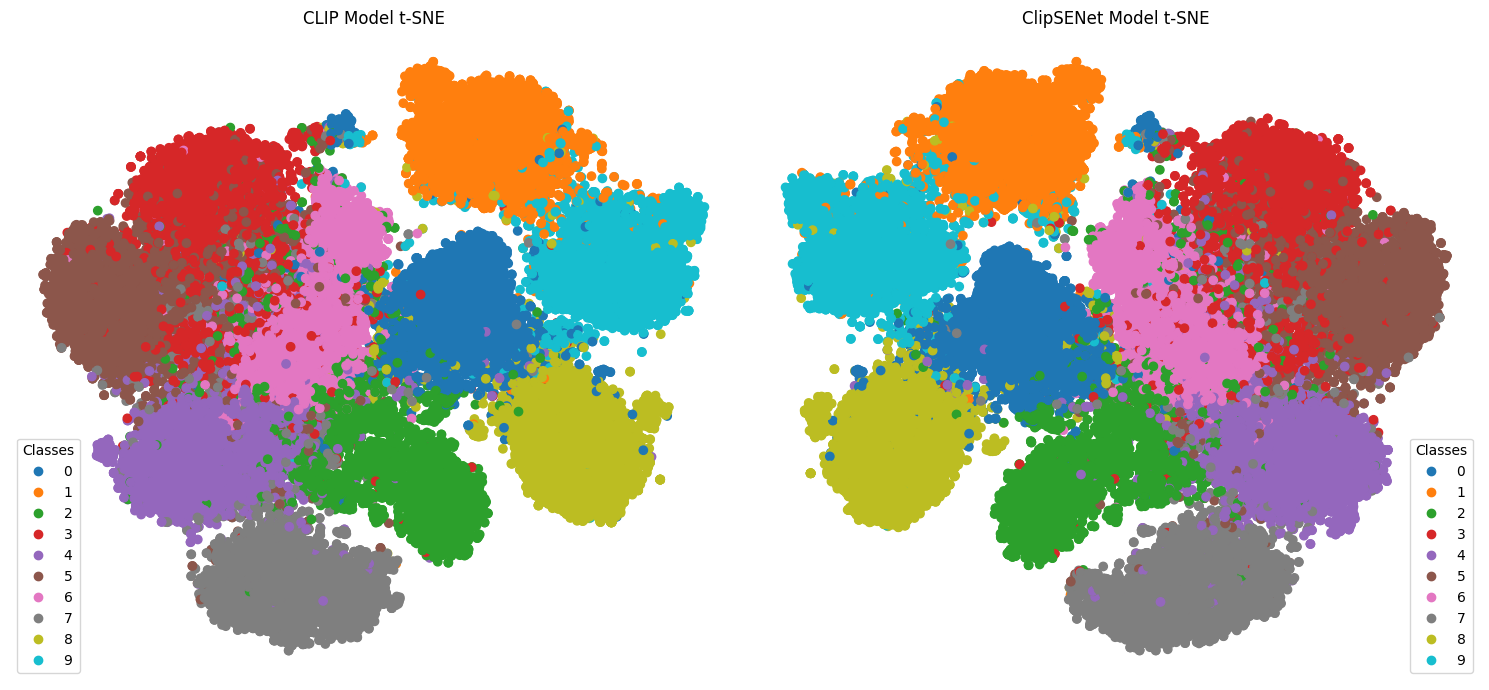

In [6]:
import torch
import clip
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import numpy as np
from sklearn.manifold import TSNE

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device)


clip_model = clip_model.to(torch.float32)


for param in clip_model.parameters():
    param.requires_grad = False


class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction_ratio)
        self.fc2 = nn.Linear(in_channels // reduction_ratio, in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size, channels, _, _ = x.size()
        y = x.mean(dim=[2, 3], keepdim=True)
        y = self.fc1(y.view(batch_size, channels))
        y = self.fc2(y)
        y = self.sigmoid(y).view(batch_size, channels, 1, 1)
        return x * y


class ClipSENet(nn.Module):
    def __init__(self, clip_model, num_classes=10):
        super(ClipSENet, self).__init__()
        self.clip_model = clip_model
        self.se_block = SEBlock(512)
    def forward(self, images):

        images = images.to(torch.float32)


        with torch.no_grad():
            image_features = self.clip_model.encode_image(images)


        image_features = self.se_block(image_features.unsqueeze(-1).unsqueeze(-1))
        image_features = image_features.squeeze(-1).squeeze(-1)

        return image_features

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)


clip_model.eval()
clip_senet_model = ClipSENet(clip_model=clip_model).to(device)


clip_features = []
clip_senet_features = []
labels = []


for images, label in train_loader:
    images = images.to(device)


    images = images.to(torch.float32)

    with torch.no_grad():

        clip_features_batch = clip_model.encode_image(images)
        clip_features.append(clip_features_batch.cpu().numpy())


        clip_senet_features_batch = clip_senet_model(images)
        clip_senet_features.append(clip_senet_features_batch.cpu().numpy())

        labels.append(label.numpy())


clip_features = np.concatenate(clip_features, axis=0)
clip_senet_features = np.concatenate(clip_senet_features, axis=0)
labels = np.concatenate(labels, axis=0)


tsne_clip = TSNE(n_components=2, random_state=42).fit_transform(clip_features)
tsne_clip_senet = TSNE(n_components=2, random_state=42).fit_transform(clip_senet_features)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))


scatter1 = ax1.scatter(tsne_clip[:, 0], tsne_clip[:, 1], c=labels, cmap='tab10')
ax1.set_title("CLIP Model t-SNE")
ax1.axis('off')
ax1.legend(*scatter1.legend_elements(), title="Classes")


scatter2 = ax2.scatter(tsne_clip_senet[:, 0], tsne_clip_senet[:, 1], c=labels, cmap='tab10')
ax2.set_title("ClipSENet Model t-SNE")
ax2.axis('off')
ax2.legend(*scatter2.legend_elements(), title="Classes")

plt.tight_layout()
plt.show()
